In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
df = pd.read_json("politifact_factcheck_data.json", lines=True)

In [3]:
df

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...
...,...,...,...,...,...,...,...,...
21147,mostly-false,Donald Trump,Says the large trade deficit with Japan stems ...,8/13/2019,speech,Jon Greenberg,8/15/2019,https://www.politifact.com/factchecks/2019/aug...
21148,false,Donald Trump Jr.,"""Tens of thousands"" of people leave New York e...",11/1/2019,social_media,Jill Terreri Ramos,11/8/2019,https://www.politifact.com/factchecks/2019/nov...
21149,mostly-false,Chris Abele,"""I have fought for our shared values without b...",1/4/2011,news,Dave Umhoefer,1/13/2011,https://www.politifact.com/factchecks/2011/jan...
21150,false,Bloggers,"""Germany halts all Covid-19 vaccines, says the...",8/27/2021,blog,Ciara O'Rourke,9/9/2021,https://www.politifact.com/factchecks/2021/sep...


In [4]:
df_c=(set(df.verdict.values))
df_c=['false', 'half-true', 'mostly-false', 'mostly-true', 'pants-fire', 'true']

In [5]:
from sklearn.preprocessing import OneHotEncoder
oh=OneHotEncoder()
oh.fit(df[['verdict']])
values=oh.transform(df[['verdict']]).toarray()
df_1=pd.DataFrame(values,columns=df_c)
df_1

,false,half-true,mostly-false,mostly-true,pants-fire,true
0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
21147,0.0,0.0,1.0,0.0,0.0,0.0
21148,1.0,0.0,0.0,0.0,0.0,0.0
21149,0.0,0.0,1.0,0.0,0.0,0.0
21150,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
new_df=pd.concat([df,df_1],axis=1)
new_df

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,false,half-true,mostly-false,mostly-true,pants-fire,true
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...,0.0,0.0,0.0,0.0,0.0,1.0
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...,1.0,0.0,0.0,0.0,0.0,0.0
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...,0.0,0.0,0.0,1.0,0.0,0.0
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...,1.0,0.0,0.0,0.0,0.0,0.0
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,mostly-false,Donald Trump,Says the large trade deficit with Japan stems ...,8/13/2019,speech,Jon Greenberg,8/15/2019,https://www.politifact.com/factchecks/2019/aug...,0.0,0.0,1.0,0.0,0.0,0.0
21148,false,Donald Trump Jr.,"""Tens of thousands"" of people leave New York e...",11/1/2019,social_media,Jill Terreri Ramos,11/8/2019,https://www.politifact.com/factchecks/2019/nov...,1.0,0.0,0.0,0.0,0.0,0.0
21149,mostly-false,Chris Abele,"""I have fought for our shared values without b...",1/4/2011,news,Dave Umhoefer,1/13/2011,https://www.politifact.com/factchecks/2011/jan...,0.0,0.0,1.0,0.0,0.0,0.0
21150,false,Bloggers,"""Germany halts all Covid-19 vaccines, says the...",8/27/2021,blog,Ciara O'Rourke,9/9/2021,https://www.politifact.com/factchecks/2021/sep...,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df=new_df.drop(['statement_originator','statement_date','verdict','statement_source','factchecker','factcheck_analysis_link','factcheck_date'],axis=1)
df

,statement,false,half-true,mostly-false,mostly-true,pants-fire,true
0,John McCain opposed bankruptcy protections for...,0.0,0.0,0.0,0.0,0.0,1.0
1,"""Bennie Thompson actively cheer-led riots in t...",1.0,0.0,0.0,0.0,0.0,0.0
2,"Says Maggie Hassan was ""out of state on 30 day...",0.0,0.0,0.0,1.0,0.0,0.0
3,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",1.0,0.0,0.0,0.0,0.0,0.0
4,"""I'm the only (Republican) candidate that has ...",0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21147,Says the large trade deficit with Japan stems ...,0.0,0.0,1.0,0.0,0.0,0.0
21148,"""Tens of thousands"" of people leave New York e...",1.0,0.0,0.0,0.0,0.0,0.0
21149,"""I have fought for our shared values without b...",0.0,0.0,1.0,0.0,0.0,0.0
21150,"""Germany halts all Covid-19 vaccines, says the...",1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
counts = []
df_count=df.drop(['statement'],axis=1)
categories = list(df_count.columns.values)
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,false,5625.0
1,half-true,3597.0
2,mostly-false,3432.0
3,mostly-true,3332.0
4,pants-fire,2703.0
5,true,2463.0


Text(0.5, 0, 'category')

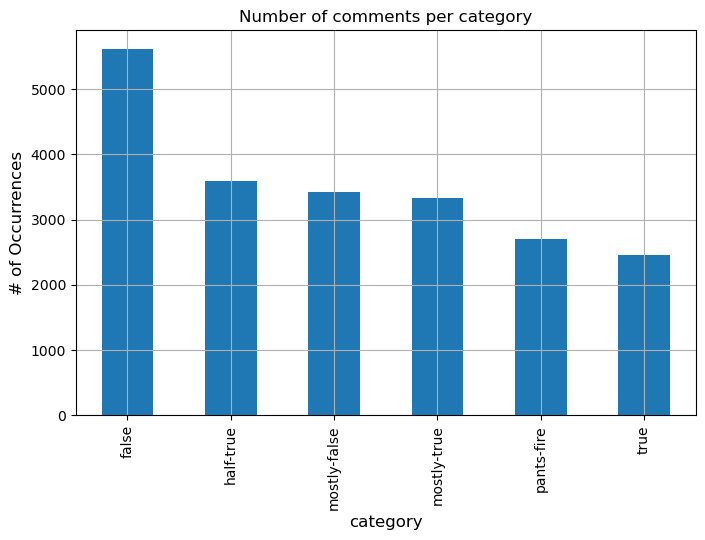

In [9]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [10]:
df.statement.isnull().sum()

0

In [11]:
categories

['false', 'half-true', 'mostly-false', 'mostly-true', 'pants-fire', 'true']

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [13]:
df['statement'] = df['statement'].map(lambda com : clean_text(com))

In [14]:
df['statement'][0]

'john mccain opposed bankruptcy protections for families who were only in bankruptcy because of medical expenses they could not pay'

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
train, test = train_test_split(df, random_state=12, test_size=0.20, shuffle=True)

In [17]:
X_train = train.statement
X_test = test.statement
print(X_train.shape)
print(X_test.shape)

(16921,)
(4231,)


In [18]:
train

,statement,false,half-true,mostly-false,mostly-true,pants-fire,true
5676,says miami congressman carlos curbelo supports...,0.0,0.0,1.0,0.0,0.0,0.0
17256,even members of the nra when they were polled ...,0.0,0.0,0.0,1.0,0.0,0.0
11621,the climatic research unit e mails show that t...,1.0,0.0,0.0,0.0,0.0,0.0
2159,the impact of president biden being beholden t...,1.0,0.0,0.0,0.0,0.0,0.0
10967,photo shows empire state building lit up to su...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
3714,you have areas of pennsylvania that are barely...,0.0,1.0,0.0,0.0,0.0,0.0
7409,children who receive covid 19 vaccinations wil...,1.0,0.0,0.0,0.0,0.0,0.0
19709,says chuck hagel opposed sanctions against iran,0.0,1.0,0.0,0.0,0.0,0.0
5787,we have the highest funding in the k 12 system...,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

... Processing false
Test accuracy is 0.7506499645473883
classification_report is               precision    recall  f1-score   support

         0.0       0.75      0.99      0.85      3137
         1.0       0.67      0.07      0.13      1094

    accuracy                           0.75      4231
   macro avg       0.71      0.53      0.49      4231
weighted avg       0.73      0.75      0.67      4231

confusion_matrix is 
[[3099   38]
 [1017   77]]


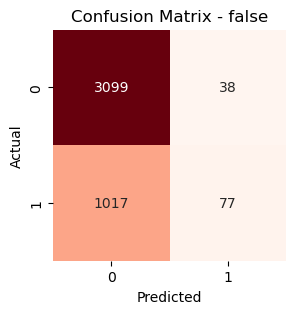

---------------------------------------------------------------------------------------------------------------
... Processing half-true
Test accuracy is 0.8359725833136374
classification_report is               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      3537
         1.0       0.00      0.00      0.00       694

    accuracy                           0.84      4231
   macro avg       0.42      0.50      0.46      4231
weighted avg       0.70      0.84      0.76      4231

confusion_matrix is 
[[3537    0]
 [ 694    0]]


C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


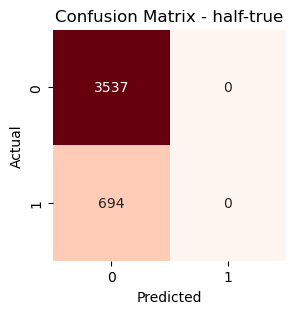

---------------------------------------------------------------------------------------------------------------
... Processing mostly-false
Test accuracy is 0.8406995982037343
classification_report is               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      3557
         1.0       0.00      0.00      0.00       674

    accuracy                           0.84      4231
   macro avg       0.42      0.50      0.46      4231
weighted avg       0.71      0.84      0.77      4231

confusion_matrix is 
[[3557    0]
 [ 674    0]]


C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


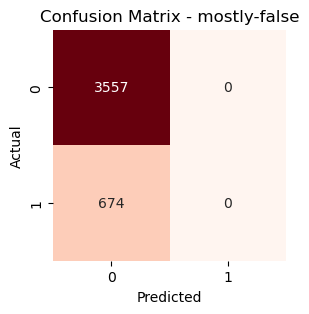

---------------------------------------------------------------------------------------------------------------
... Processing mostly-true
Test accuracy is 0.8272276057669582
classification_report is               precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      3500
         1.0       0.00      0.00      0.00       731

    accuracy                           0.83      4231
   macro avg       0.41      0.50      0.45      4231
weighted avg       0.68      0.83      0.75      4231

confusion_matrix is 
[[3500    0]
 [ 731    0]]


C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


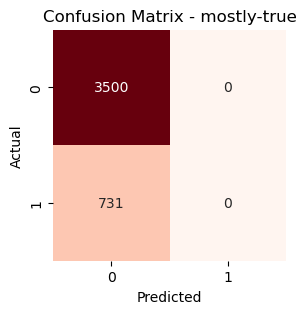

---------------------------------------------------------------------------------------------------------------
... Processing pants-fire
Test accuracy is 0.8770976128574804
classification_report is               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      3711
         1.0       0.50      0.00      0.01       520

    accuracy                           0.88      4231
   macro avg       0.69      0.50      0.47      4231
weighted avg       0.83      0.88      0.82      4231

confusion_matrix is 
[[3709    2]
 [ 518    2]]


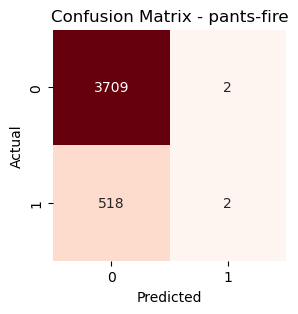

---------------------------------------------------------------------------------------------------------------
... Processing true
Test accuracy is 0.8775703143464902
classification_report is               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      3713
         1.0       0.00      0.00      0.00       518

    accuracy                           0.88      4231
   macro avg       0.44      0.50      0.47      4231
weighted avg       0.77      0.88      0.82      4231

confusion_matrix is 
[[3713    0]
 [ 518    0]]


C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


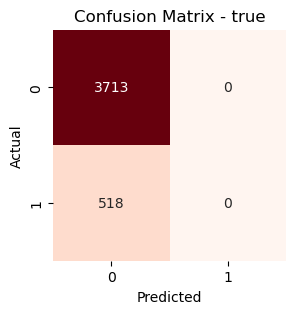

---------------------------------------------------------------------------------------------------------------
Naive Bayes accuracy = 83.49


In [20]:
Naive_Bayes=0
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('classification_report is {}'.format(classification_report(test[category], prediction)))
    conf_matrix = confusion_matrix(test[category], prediction)
    print('confusion_matrix is \n{}'.format(conf_matrix))
    
    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.title(f'Confusion Matrix - {category}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print('---------------------------------------------------------------------------------------------------------------')
    
    Naive_Bayes+=accuracy_score(test[category], prediction)
NB=round((Naive_Bayes / len(categories)) * 100, 2)
print('Naive Bayes accuracy =',NB)      

In [21]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

... Processing false
Test accuracy is 0.7199243677617585
classification_report is               precision    recall  f1-score   support

         0.0       0.77      0.88      0.82      3137
         1.0       0.43      0.26      0.32      1094

    accuracy                           0.72      4231
   macro avg       0.60      0.57      0.57      4231
weighted avg       0.68      0.72      0.69      4231

confusion_matrix is 
[[2763  374]
 [ 811  283]]


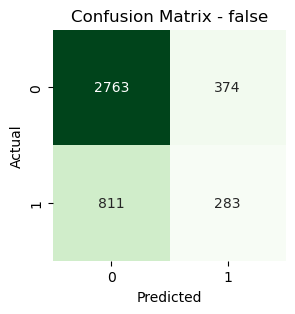

---------------------------------------------------------------------------------------------------------------
... Processing half-true
Test accuracy is 0.8054833372725124
classification_report is               precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      3537
         1.0       0.25      0.09      0.14       694

    accuracy                           0.81      4231
   macro avg       0.55      0.52      0.51      4231
weighted avg       0.74      0.81      0.77      4231

confusion_matrix is 
[[3343  194]
 [ 629   65]]


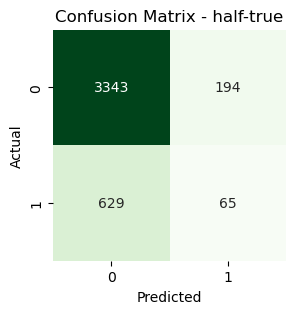

---------------------------------------------------------------------------------------------------------------
... Processing mostly-false
Test accuracy is 0.819900732687308
classification_report is               precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      3557
         1.0       0.27      0.07      0.12       674

    accuracy                           0.82      4231
   macro avg       0.56      0.52      0.51      4231
weighted avg       0.75      0.82      0.77      4231

confusion_matrix is 
[[3419  138]
 [ 624   50]]


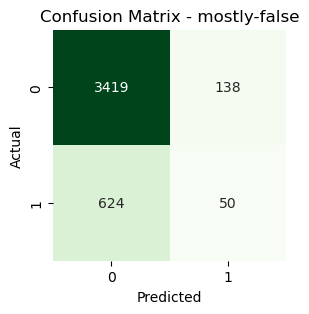

---------------------------------------------------------------------------------------------------------------
... Processing mostly-true
Test accuracy is 0.8019380761049397
classification_report is               precision    recall  f1-score   support

         0.0       0.83      0.95      0.89      3500
         1.0       0.27      0.08      0.13       731

    accuracy                           0.80      4231
   macro avg       0.55      0.52      0.51      4231
weighted avg       0.73      0.80      0.76      4231

confusion_matrix is 
[[3332  168]
 [ 670   61]]


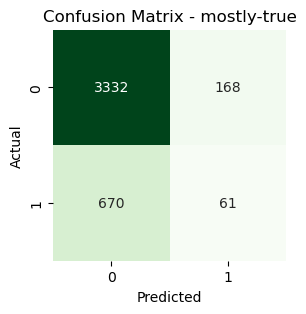

---------------------------------------------------------------------------------------------------------------
... Processing pants-fire
Test accuracy is 0.8707161427558496
classification_report is               precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      3711
         1.0       0.44      0.20      0.27       520

    accuracy                           0.87      4231
   macro avg       0.67      0.58      0.60      4231
weighted avg       0.84      0.87      0.85      4231

confusion_matrix is 
[[3582  129]
 [ 418  102]]


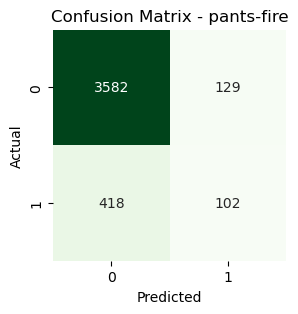

---------------------------------------------------------------------------------------------------------------
... Processing true
Test accuracy is 0.861025762231151
classification_report is               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      3713
         1.0       0.22      0.05      0.08       518

    accuracy                           0.86      4231
   macro avg       0.55      0.51      0.50      4231
weighted avg       0.80      0.86      0.82      4231

confusion_matrix is 
[[3616   97]
 [ 491   27]]


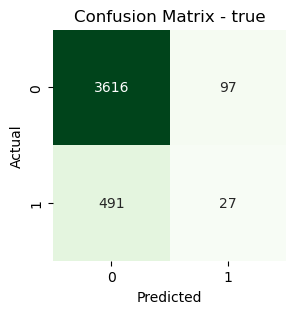

---------------------------------------------------------------------------------------------------------------
SVM accuracy = 81.32


In [27]:
SVM=0
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('classification_report is {}'.format(classification_report(test[category], prediction)))
    
    conf_matrix = confusion_matrix(test[category], prediction)
    print('confusion_matrix is \n{}'.format(conf_matrix))
    
    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(f'Confusion Matrix - {category}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print('---------------------------------------------------------------------------------------------------------------')
    SVM+=accuracy_score(test[category], prediction)
SVM_=round((SVM / len(categories)) * 100, 2)
print('SVM accuracy =',SVM_)      

... Processing false
Test accuracy is 0.7513590167809029
classification_report is               precision    recall  f1-score   support

         0.0       0.76      0.97      0.85      3137
         1.0       0.58      0.14      0.22      1094

    accuracy                           0.75      4231
   macro avg       0.67      0.55      0.54      4231
weighted avg       0.72      0.75      0.69      4231

confusion_matrix is 
[[3028  109]
 [ 943  151]]


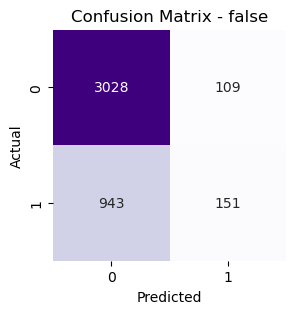

---------------------------------------------------------------------------------------------------------------
... Processing half-true
Test accuracy is 0.8350271803356181
classification_report is               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      3537
         1.0       0.36      0.01      0.01       694

    accuracy                           0.84      4231
   macro avg       0.60      0.50      0.46      4231
weighted avg       0.76      0.84      0.76      4231

confusion_matrix is 
[[3528    9]
 [ 689    5]]


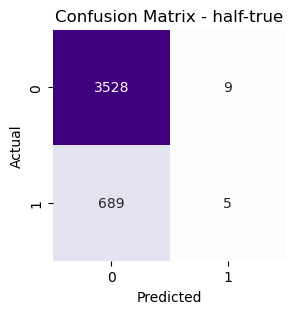

---------------------------------------------------------------------------------------------------------------
... Processing mostly-false
Test accuracy is 0.8406995982037343
classification_report is               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      3557
         1.0       0.50      0.00      0.01       674

    accuracy                           0.84      4231
   macro avg       0.67      0.50      0.46      4231
weighted avg       0.79      0.84      0.77      4231

confusion_matrix is 
[[3555    2]
 [ 672    2]]


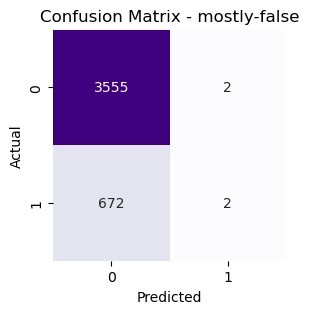

---------------------------------------------------------------------------------------------------------------
... Processing mostly-true
Test accuracy is 0.8255731505554242
classification_report is               precision    recall  f1-score   support

         0.0       0.83      1.00      0.90      3500
         1.0       0.32      0.01      0.02       731

    accuracy                           0.83      4231
   macro avg       0.57      0.50      0.46      4231
weighted avg       0.74      0.83      0.75      4231

confusion_matrix is 
[[3487   13]
 [ 725    6]]


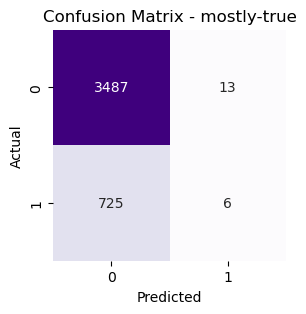

---------------------------------------------------------------------------------------------------------------
... Processing pants-fire
Test accuracy is 0.8804065232805484
classification_report is               precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      3711
         1.0       0.72      0.04      0.08       520

    accuracy                           0.88      4231
   macro avg       0.80      0.52      0.51      4231
weighted avg       0.86      0.88      0.83      4231

confusion_matrix is 
[[3702    9]
 [ 497   23]]


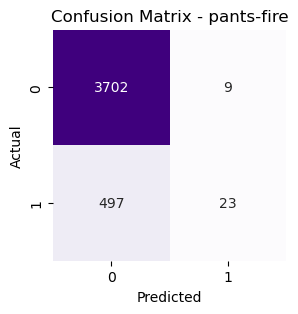

---------------------------------------------------------------------------------------------------------------
... Processing true
Test accuracy is 0.8768612621129757
classification_report is               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      3713
         1.0       0.00      0.00      0.00       518

    accuracy                           0.88      4231
   macro avg       0.44      0.50      0.47      4231
weighted avg       0.77      0.88      0.82      4231

confusion_matrix is 
[[3710    3]
 [ 518    0]]


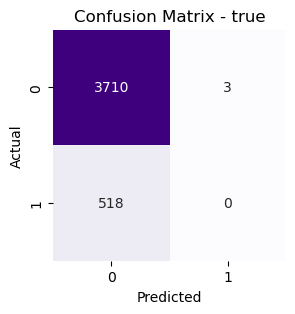

---------------------------------------------------------------------------------------------------------------
Logistic Regression accuracy = 83.5


In [23]:
Logistic_Regression=0
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('classification_report is {}'.format(classification_report(test[category], prediction)))
    conf_matrix = confusion_matrix(test[category], prediction)
    print('confusion_matrix is \n{}'.format(conf_matrix))
    
    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', cbar=False)
    plt.title(f'Confusion Matrix - {category}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print('---------------------------------------------------------------------------------------------------------------')
    
    Logistic_Regression+=accuracy_score(test[category], prediction)
    LR=round((Logistic_Regression / len(categories)) * 100, 2)
print('Logistic Regression accuracy =',LR)  

... Processing false
Test accuracy is 0.7497045615693689
classification_report is 
              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85      3137
         1.0       0.55      0.17      0.26      1094

    accuracy                           0.75      4231
   macro avg       0.66      0.56      0.55      4231
weighted avg       0.71      0.75      0.70      4231

confusion_matrix is 
[[2987  150]
 [ 909  185]]


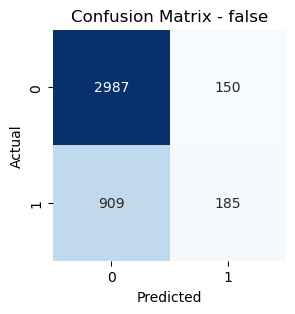

---------------------------------------------------------------------------------------------------------------
... Processing half-true
Test accuracy is 0.8298274639565114
classification_report is 
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      3537
         1.0       0.23      0.02      0.03       694

    accuracy                           0.83      4231
   macro avg       0.53      0.50      0.47      4231
weighted avg       0.74      0.83      0.76      4231

confusion_matrix is 
[[3500   37]
 [ 683   11]]


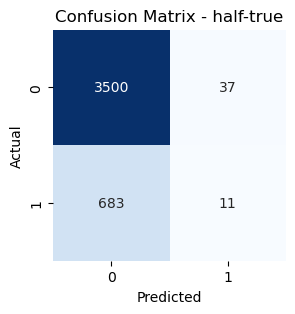

---------------------------------------------------------------------------------------------------------------
... Processing mostly-false
Test accuracy is 0.833609075868589
classification_report is 
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      3557
         1.0       0.25      0.02      0.04       674

    accuracy                           0.83      4231
   macro avg       0.55      0.50      0.47      4231
weighted avg       0.75      0.83      0.77      4231

confusion_matrix is 
[[3512   45]
 [ 659   15]]


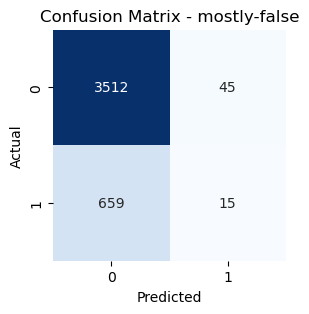

---------------------------------------------------------------------------------------------------------------
... Processing mostly-true
Test accuracy is 0.8267549042779485
classification_report is 
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.90      3500
         1.0       0.46      0.02      0.03       731

    accuracy                           0.83      4231
   macro avg       0.65      0.51      0.47      4231
weighted avg       0.77      0.83      0.75      4231

confusion_matrix is 
[[3485   15]
 [ 718   13]]


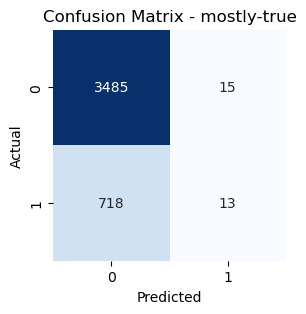

---------------------------------------------------------------------------------------------------------------
... Processing pants-fire
Test accuracy is 0.8796974710470338
classification_report is 
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.94      3711
         1.0       0.58      0.07      0.13       520

    accuracy                           0.88      4231
   macro avg       0.73      0.53      0.53      4231
weighted avg       0.85      0.88      0.84      4231

confusion_matrix is 
[[3684   27]
 [ 482   38]]


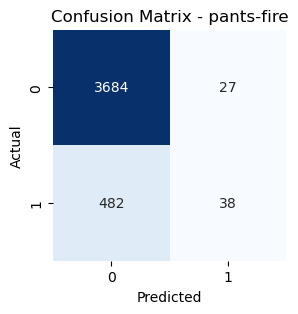

---------------------------------------------------------------------------------------------------------------
... Processing true
Test accuracy is 0.8761522098794611
classification_report is 
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      3713
         1.0       0.31      0.01      0.02       518

    accuracy                           0.88      4231
   macro avg       0.60      0.50      0.48      4231
weighted avg       0.81      0.88      0.82      4231

confusion_matrix is 
[[3702   11]
 [ 513    5]]


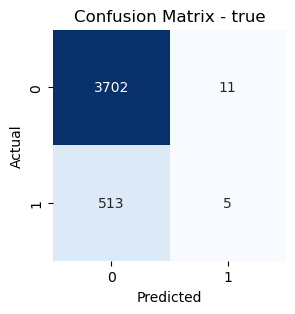

---------------------------------------------------------------------------------------------------------------
Overall accuracy = 83.26


In [24]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

RandomForest = 0

RandomForest_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42), n_jobs=1)),
])

for category in categories:
    print('... Processing {}'.format(category))
    # Train the model using X_dtm & y
    RandomForest_pipeline.fit(X_train, train[category])
    # Compute the testing accuracy
    prediction = RandomForest_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('classification_report is \n{}'.format(classification_report(test[category], prediction)))
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(test[category], prediction)
    print('confusion_matrix is \n{}'.format(conf_matrix))
    
    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {category}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print('---------------------------------------------------------------------------------------------------------------')
    
    RandomForest += accuracy_score(test[category], prediction)
RandomForest_=round((RandomForest / len(categories)) * 100, 2)

print('Overall accuracy =', RandomForest_)


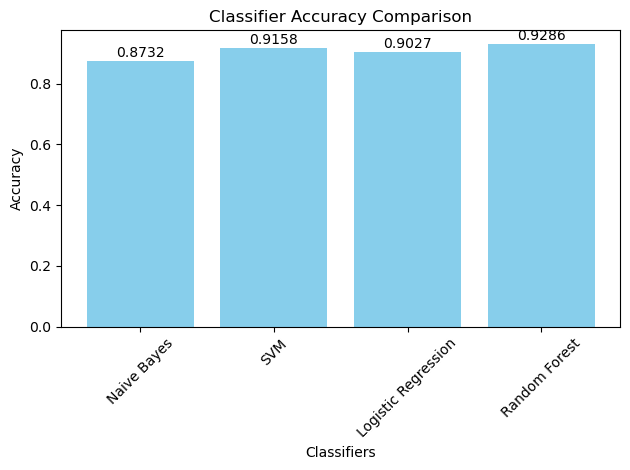

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

classifiers = ['Naive Bayes', 'SVM', 'Logistic Regression', 'Random Forest']
accuracies = [0.8732165, 0.9158432, 0.9027438, 0.9286421]  


color = 'skyblue'

plt.bar(classifiers, accuracies, color=color)

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')

# Display accuracy values above each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# Display classifier names below the bars

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
